In [1]:
# Install dependencies
# !pip install pandas torch matplotlib scikit-learn

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
device = torch.device('cuda:0')


In [3]:
# Read the data
df = pd.read_csv(os.path.join('/content/gdrive/MyDrive/Machine Learning/CommentToxicityModel/jigsaw-toxic-comment-classification-challenge', 'train.csv','train.csv'))

x = df['comment_text']
y = df[df.columns[2:]].values

In [4]:
# Preprocess the text
MAX_FEATURES = 2000
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
x = vectorizer.fit_transform(x)

In [5]:
# Split the data into train, validation, and test sets
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.33, random_state=42)

In [6]:
# Define the custom dataset
class CommentDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.toarray()).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [7]:
# Create the data loaders
batch_size = 16
train_dataset = CommentDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CommentDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = CommentDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# Define the model
class CommentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CommentModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(32, hidden_size, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long() #convert  to Long Tensor
        embedded = self.embedding(x)
        embedded = embedded.permute(1, 0, 2)
        output, _ = self.lstm(embedded)
        output = output[-1, :, :]
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.fc4(output)
        output = self.sigmoid(output)
        return output

In [9]:
# Create the model
input_size = MAX_FEATURES + 1
hidden_size = 32
output_size = 6
model = CommentModel(input_size, hidden_size, output_size).to(device)

In [10]:
model = nn.DataParallel(model)

In [11]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [12]:
# Train the model
epochs = 100
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)  # Move inputs to GPU
        targets = targets.to(device)  # Move targets to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)  # Move inputs to GPU
            targets = targets.to(device)  # Move targets to GPU
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/100 - Train Loss: 0.1421 - Val Loss: 0.1404
Epoch 2/100 - Train Loss: 0.1319 - Val Loss: 0.1269
Epoch 3/100 - Train Loss: 0.1239 - Val Loss: 0.1239
Epoch 4/100 - Train Loss: 0.1222 - Val Loss: 0.1303
Epoch 5/100 - Train Loss: 0.1210 - Val Loss: 0.1232
Epoch 6/100 - Train Loss: 0.1206 - Val Loss: 0.1242
Epoch 7/100 - Train Loss: 0.1200 - Val Loss: 0.1238
Epoch 8/100 - Train Loss: 0.1196 - Val Loss: 0.1224
Epoch 9/100 - Train Loss: 0.1192 - Val Loss: 0.1222
Epoch 10/100 - Train Loss: 0.1189 - Val Loss: 0.1230
Epoch 11/100 - Train Loss: 0.1186 - Val Loss: 0.1212
Epoch 12/100 - Train Loss: 0.1184 - Val Loss: 0.1222
Epoch 13/100 - Train Loss: 0.1180 - Val Loss: 0.1215
Epoch 14/100 - Train Loss: 0.1179 - Val Loss: 0.1209
Epoch 15/100 - Train Loss: 0.1176 - Val Loss: 0.1211
Epoch 16/100 - Train Loss: 0.1174 - Val Loss: 0.1215
Epoch 17/100 - Train Loss: 0.1173 - Val Loss: 0.1208
Epoch 18/100 - Train Loss: 0.1171 - Val Loss: 0.1206
Epoch 19/100 - Train Loss: 0.1169 - Val Loss: 0.1214
Ep

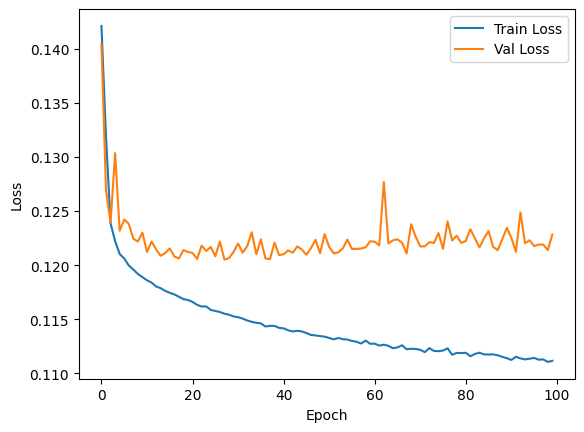

In [13]:
# Plot the training and validation losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Evaluate the model on the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        y_true.extend(targets.tolist())
        y_pred.extend(predicted.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [15]:
# Calculate precision, recall, and accuracy
precision = precision_score(y_true, y_pred, average="micro")
recall = recall_score(y_true, y_pred, average="micro")
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")

Precision: 0.5458, Recall: 0.1127, Accuracy: 0.8921


In [16]:
torch.save(model, 'toxicitypytorch.pth')